In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import glob

from scipy.interpolate import interp1d

2024-10-16 13:43:53.286451: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 13:43:53.303564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:43:53.322214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 13:43:53.327955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 13:43:53.342179: I tensorflow/core/platform/cpu_feature_guar

# Pendulum

In [2]:
env_name = 'Pendulum'

file_list = glob.glob(f'../runs/{env_name}__baseline__*/events.out.tfevents.*')
# file_list += glob.glob(f"../runs/{env_name}__dicl-sac-5p-sPCA__*/events.out.tfevents.*")
# file_list += glob.glob(f"../runs/{env_name}__dicl-sac-5p-saPCA__*/events.out.tfevents.*")
file_list += glob.glob(f"../runs/{env_name}__dicl-sac-5p-true__*/events.out.tfevents.*")


max_steps = int(1e4)
moving_average_window = 1

data_frames = []
interp_data_frames = []
moving_average_data_frames = []
for file in file_list:
    # Load the event file
    event_acc = tf.compat.v1.train.summary_iterator(file)

    only_first = True
    
    # Extract data
    steps = []
    values = []
    for e in event_acc:
        for v in e.summary.value:
            if v.tag == 'charts/episodic_return':
                steps.append(e.step)
                values.append(v.simple_value)
                df = pd.DataFrame(
                    np.concatenate(
                        [
                            np.array(steps)[..., None], 
                            np.array(values)[..., None]
                        ], axis=1
                    ), columns=['Step', 'Value']
                )
                if int(np.max(df['Step'].values)) >= max_steps:
                    if only_first:
                        print(file)
                        only_first = False
                        # Extract the algorithm variation from the filename
                        df['Variation'] = file.split('/')[-2].split('__')[1]
                        df['seed'] = file.split('/')[-2].split('__')[2]
                        df['Episode'] = np.arange(len(df))
                        # interpolation
                        f = interp1d(
                            # x=np.concatenate([np.array([0]), df['Step'].values], axis=0),
                            x=df['Step'].values,
                            # y=np.concatenate([np.array([0]), df['Value'].values], axis=0),
                            y=df['Value'].values,
                        )
                        # all_steps = np.arange(1, int(np.max(df['Step'].values)), 100)
                        all_steps = np.arange(np.min(df['Step'].values), max_steps, 100)
                        all_returns = f(all_steps)
                        interp_df = pd.DataFrame(np.concatenate([all_steps[..., None], all_returns[..., None]], axis=1), columns=['Step', 'Value']) 
                        interp_df['Variation'] = file.split('/')[-2].split('__')[1]
                        interp_df['seed'] = file.split('/')[-2].split('__')[2]
                        data_frames.append(df)
                        interp_data_frames.append(interp_df)

                        # moving averages
                        smoothed = interp_df['Value'].rolling(window=moving_average_window).mean().to_numpy()[..., None]
                        mvav_df = pd.DataFrame(np.concatenate([all_steps[-len(smoothed):][..., None], smoothed], axis=1), columns=['Step', 'Value']) 
                        mvav_df['Variation'] = file.split('/')[-2].split('__')[1]
                        mvav_df['seed'] = file.split('/')[-2].split('__')[2]
                        moving_average_data_frames.append(mvav_df)
                    

# Concatenate all DataFrames
df_all = pd.concat(data_frames, ignore_index=True)
interp_df_all = pd.concat(interp_data_frames, ignore_index=True)
moving_average_df_all = pd.concat(moving_average_data_frames, ignore_index=True)

moving_average_df_all

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
../runs/Pendulum__baseline__25242__1728919519/events.out.tfevents.1728919519.autodsgpularge1.2757009.0
../runs/Pendulum__baseline__18776__1728994197/events.out.tfevents.1728994197.autodsgpularge1.2782058.0
../runs/Pendulum__baseline__23358__1728919533/events.out.tfevents.1728919533.autodsgpularge1.2757307.0
../runs/Pendulum__baseline__23933__1728994184/events.out.tfevents.1728994184.autodsgpularge1.2781634.0
../runs/Pendulum__baseline__18632__1728919536/events.out.tfevents.1728919536.autodsgpularge1.2757383.0
../runs/Pendulum__baseline__175__1728991264/events.out.tfevents.1728991264.autodsgpularge1.2778724.0
../runs/Pendulum__baseline__3465__1728991249/events.out.tfevents.1728991249.autodsgpularge1.2778423.0
../runs/Pendulum__baseline__2306__1728919509/events.out.tfevents.1728919509.autodsgpularge1.2756866.0
../runs/Pendulum__baseline__2529__1728919522/events.out.tfevents.1728919522.autodsgpularge1.275

,Step,Value,Variation,seed
0,200.0,-1461.800537,baseline,25242
1,300.0,-1424.989624,baseline,25242
2,400.0,-1388.178711,baseline,25242
3,500.0,-1564.989868,baseline,25242
4,600.0,-1741.801025,baseline,25242
...,...,...,...,...
3915,9500.0,-60.507946,dicl-sac-5p-true,16354
3916,9600.0,-3.986488,dicl-sac-5p-true,16354
3917,9700.0,-60.731632,dicl-sac-5p-true,16354
3918,9800.0,-117.476776,dicl-sac-5p-true,16354


n_seeds for baseline: 30
n_seeds for dicl-sac-5p-true: 10


<Figure size 640x480 with 0 Axes>

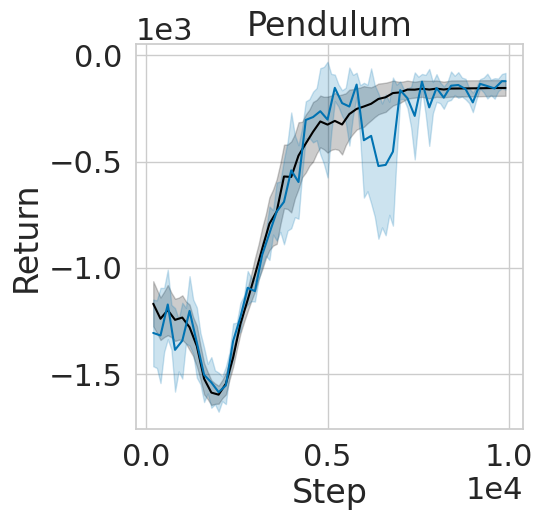

In [3]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

# Group by variation and step, then calculate mean and std
# grouped = interp_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()
grouped = (
    moving_average_df_all.groupby(["Variation", "Step"])["Value"]
    .agg(["mean", "std"])
    .reset_index()
)
# Plot the performance curves with mean and std
plt.figure(figsize=(5, 5))
colors = plt.get_cmap('tab10', 8)  # Use a color map

variations = grouped['Variation'].unique()
for i, variation in enumerate(variations):
    variation_data = grouped[grouped['Variation'] == variation]

    if '+' in variation:
        label = variation.split('_')[3]
    else:
        label = 'sac'
    n_seeds = len(moving_average_df_all.loc[moving_average_df_all['Variation'] == variation]['seed'].unique())
    print(f"n_seeds for {variation}: {n_seeds}")
    if variation == "dicl-sac-5p-true":
        color = sns.color_palette("colorblind")[0]
    elif variation == "dicl-sac-5p-sPCA":
        color = sns.color_palette("colorblind")[1]
    elif variation == "dicl-sac-5p-saPCA":
        color = sns.color_palette("colorblind")[2]
    elif 'baseline' in variation:
        color = 'black'
    plt.plot(
        variation_data["Step"][:max_steps],
        variation_data["mean"][:max_steps],
        alpha=1.0,
        color=color,
        label=label,
    )
    plt.fill_between(
        variation_data["Step"][:max_steps],
        variation_data["mean"][:max_steps]
        - 1.96 * variation_data["std"][:max_steps] / np.sqrt(n_seeds),
        variation_data["mean"][:max_steps]
        + 1.96 * variation_data["std"][:max_steps] / np.sqrt(n_seeds),
        alpha=0.2,
        color=color,
    )
    # smoothed_mean = variation_data['mean'].rolling(window=100).mean()
    # plt.plot(variation_data['Step'][:max_steps], smoothed_mean[:max_steps], linestyle='--', color=colors(i), label=label)

plt.xlabel('Step')
plt.ylabel('Return')
plt.title(f'{env_name}')
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2))
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style='scientific', scilimits=(0,0))
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}.pdf', bbox_inches='tight')
plt.show()

### All runs

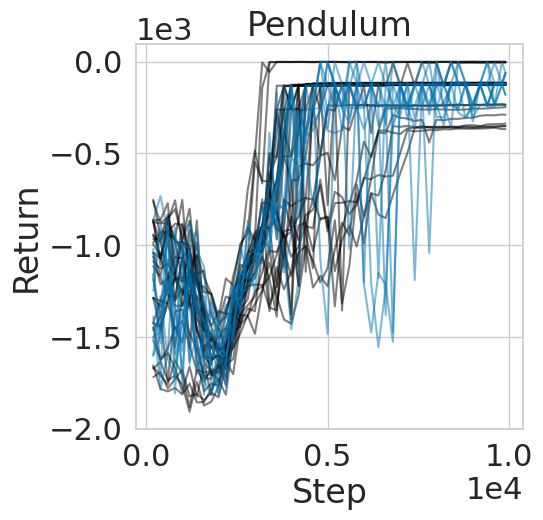

In [4]:
plt.figure(figsize=(5, 5))
colors = plt.get_cmap("tab10", 8)  # Use a color map

variations = moving_average_df_all["Variation"].unique()
for i, variation in enumerate(variations):
    variation_data = moving_average_df_all.loc[
        moving_average_df_all["Variation"] == variation
    ]

    if variation == "dicl-sac-5p-true":
        color = sns.color_palette("colorblind")[0]
    elif variation == "dicl-sac-5p-sPCA":
        color = sns.color_palette("colorblind")[1]
    elif variation == "dicl-sac-5p-saPCA":
        color = sns.color_palette("colorblind")[2]
    elif "baseline" in variation:
        color = "black"

    for seed in variation_data['seed'].unique():
        seed_data = variation_data.loc[variation_data["seed"] == seed]
        plt.plot(
            seed_data["Step"][:max_steps],
            seed_data["Value"][:max_steps],
            alpha=0.5,
            color=color,
            label=variation,
        )

plt.xlabel("Step")
plt.ylabel("Return")
plt.title(f"{env_name}")
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2))
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style="scientific", scilimits=(0, 0))
# plt.savefig(
#     f"/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}.pdf", bbox_inches="tight"
# )
plt.show()


### Interquartile mean

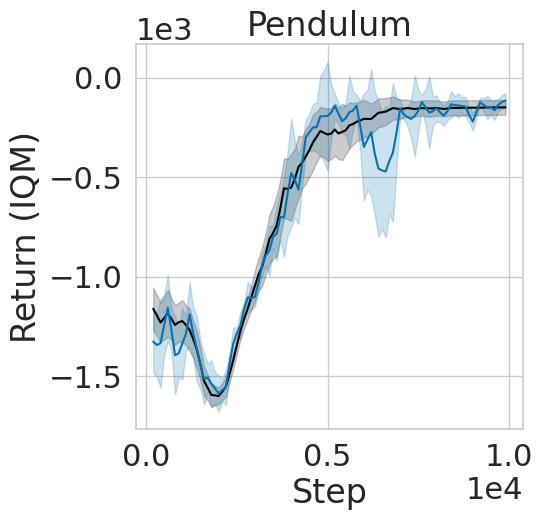

In [5]:
# Define the custom function to calculate the interquartile mean
def interquartile_mean(series):
    alpha = 0.05
    Q1 = series.quantile(alpha)
    Q3 = series.quantile(1-alpha)
    IQR_values = series[(series >= Q1) & (series <= Q3)]
    return IQR_values.mean()

grouped = (
    moving_average_df_all.groupby(["Variation", "Step"])["Value"]
    .agg(
        [
            ("iqm", interquartile_mean),  # Custom interquartile mean
            ("std", "std"),  # Standard deviation
        ]
    )
    .reset_index()
)

# Plot the performance curves with mean and std
plt.figure(figsize=(5, 5))
colors = plt.get_cmap("tab10", 8)  # Use a color map

variations = grouped["Variation"].unique()
for i, variation in enumerate(variations):
    variation_data = grouped[grouped["Variation"] == variation]

    if "+" in variation:
        label = variation.split("_")[3]
    else:
        label = "sac"
    n_seeds = len(
        moving_average_df_all.loc[moving_average_df_all["Variation"] == variation][
            "seed"
        ].unique()
    )
    if variation == "dicl-sac-5p-true":
        color = sns.color_palette("colorblind")[0]
    elif variation == "dicl-sac-5p-sPCA":
        color = sns.color_palette("colorblind")[1]
    elif variation == "dicl-sac-5p-saPCA":
        color = sns.color_palette("colorblind")[2]
    elif "baseline" in variation:
        color = "black"
    plt.plot(
        variation_data["Step"][:max_steps],
        variation_data["iqm"][:max_steps],
        alpha=1.0,
        color=color,
        label=label,
    )
    plt.fill_between(
        variation_data["Step"][:max_steps],
        variation_data["iqm"][:max_steps]
        - 1.96 * variation_data["std"][:max_steps] / np.sqrt(n_seeds),
        variation_data["iqm"][:max_steps]
        + 1.96 * variation_data["std"][:max_steps] / np.sqrt(n_seeds),
        alpha=0.2,
        color=color,
    )
    # smoothed_mean = variation_data['mean'].rolling(window=100).mean()
    # plt.plot(variation_data['Step'][:max_steps], smoothed_mean[:max_steps], linestyle='--', color=colors(i), label=label)

plt.xlabel("Step")
plt.ylabel("Return (IQM)")
plt.title(f"{env_name}")
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2))
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style="scientific", scilimits=(0, 0))
# plt.savefig(
#     f"/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}.pdf", bbox_inches="tight"
# )
plt.show()
